# Introduction & Data Import

This report analyzes the various factors that contribute to the saturation of docking stations for a bike-sharing provider. To be able to predict and mitigate the risk this occurrence, different machine learning models are run and compared. <br>
In conclusion, the report explains the identified patterns and key contributing factors, providing a rationale for the analysis results.

In [1]:
# standard libraries
import numpy             as np  # mathematical essentials
import pandas            as pd  # data science essentials
import matplotlib.pyplot as plt # data visualization
import seaborn           as sns # enhanced data viz
import warnings

# classification-specific libraries
import phik                           # phi coefficient
import statsmodels.formula.api as smf # logistic regression
import sklearn.linear_model           # logistic regression


# preprocessing and testing
from sklearn.preprocessing   import (power_transform,    # yeo-johnson
                                     StandardScaler)     # standard scaler
from sklearn.model_selection import (train_test_split,   # train-test split
                                     RandomizedSearchCV) # hp tuning
from sklearn.metrics         import (confusion_matrix,
                                     roc_auc_score, 
                                     precision_score, 
                                     recall_score,
                                     make_scorer)
from sklearn.tree            import (DecisionTreeClassifier,    # classification trees
                                     plot_tree)                 # tree plots               
from sklearn.ensemble        import (RandomForestClassifier,    # random forest
                                    GradientBoostingClassifier) # gbm   

from sklearn.model_selection import cross_val_predict


# loading data
bikes = pd.read_excel('./bikes.xlsx')


# setting pandas print options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 100)


# displaying the head of the dataset
bikes.head(n = 5)

,ID,Season,Month,DayofWeek,Hour,Temperature,Humidity,WindSpeed,Visibility,DewPointTemperature,UVIndex,Precipitation,Snowfall,Holiday,SATURATED
0,1,Winter,Jan,Sunday,3,-4.0,44,1.0,2000,-14.4,0.00,0.0,0.0,Yes,0
1,2,Winter,Jan,Sunday,13,2.4,22,2.3,1921,-17.2,1.10,0.0,0.0,Yes,0
2,3,Winter,Jan,Sunday,16,3.0,28,2.5,1864,-13.7,0.51,0.0,0.0,Yes,0
3,4,Winter,Jan,Monday,0,-1.8,54,1.1,1772,-9.8,0.00,0.0,0.0,No,0
4,5,Winter,Jan,Monday,5,-3.1,67,0.6,1384,-8.3,0.00,0.0,0.0,No,0


In [2]:
########################################
# standard_scaler
########################################
def standard_scaler(df):
    """
    Standardizes a dataset (mean = 0, variance = 1). Returns a new DataFrame.
    Requires sklearn.preprocessing.StandardScaler()
    
    PARAMETERS
    ----------
    df     | DataFrame to be used for scaling
    """

    # INSTANTIATING a StandardScaler() object
    scaler = StandardScaler(copy = True)


    # FITTING the scaler with the data
    scaler.fit(df)


    # TRANSFORMING our data after fit
    x_scaled = scaler.transform(df)

    
    # converting scaled data into a DataFrame
    new_df = pd.DataFrame(x_scaled)


    # reattaching column names
    new_df.columns = list(df.columns)
    
    return new_df



########################################
## visual_cm
########################################
def visual_cm(true_y, pred_y, labels = None):
    """
Creates a visualization of a confusion matrix.

PARAMETERS
----------
true_y : true values for the response variable
pred_y : predicted values for the response variable
labels : , default None
    """
    # visualizing the confusion matrix

    # setting labels
    lbls = labels
    

    # declaring a confusion matrix object
    cm = confusion_matrix(y_true = true_y,
                          y_pred = pred_y)


    # heatmap
    sns.heatmap(cm,
                annot       = True,
                xticklabels = lbls,
                yticklabels = lbls,
                cmap        = 'Blues',
                fmt         = 'g')


    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix of the Classifier')
    plt.show()
    
def visual_cm_RF(model, X, y, labels=None, cmap="Blues"):
    """
    Generates and visualizes a confusion matrix heatmap.

    PARAMETERS
    ----------
    model   : Trained classifier model (e.g., RandomForestClassifier)
    X       : Feature set (X-data)
    y       : Target labels (y-data)
    labels  : List of class labels (default: None)
    cmap    : Colormap for visualization (default: 'Blues')
    """

    # Train the model
    model.fit(X, y)

    # Predict using cross-validation (ensures no direct leakage)
    y_pred = cross_val_predict(model, X, y, cv=5)  # 5-fold CV

    # Compute confusion matrix
    cm = confusion_matrix(y, y_pred)

    # Create the heatmap
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='g', cmap=cmap, xticklabels=labels, yticklabels=labels)

    # Formatting
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix of the Random Forest Model")
    plt.show()

    
def classification_summary(x,
                           y,
                           model,
                           model_name   = "",
                           results_df   = None,
                           tt_split     = True,
                           test_size    = 0.25,
                           scale        = False,
                           full_tree    = False,
                           random_state = 702):
    """  
    This function is designed to generate summary statistics for the following
    classification models from scikit-learn:
    * LogisticRegression         - Logistic Regression
    * DecisionTreeClassifier     - Classification Tree
    * RandomForestClassifier     - Random Forest
    * GradientBoostingClassifier - Gradient Boosted Machine


    Additional Functionality
    ------------------------
    This function will standardize the data using StandardScaler() and create
    training and testing sets using train-test split, stratifying the
    y-variable.
    
    It will also output a tabular confusion matrix, calculate area under the
    ROC curve (AUC) for the training and testing sets, as well as the train-
    test gap.
    

    PARAMETERS
    ----------
    x            | array     | X-data before train-test split | No default.
    y            | array     | y-data before train-test split | No default.
    model        | model     | model object to instantiate    | No default.
    model_name   | str       | option to name the model       | Default = ""
    results_df   | DataFrame | place to store model results   | Default = None
    test_size    | float     | test set proportion            | Default = 0.25
    scale        | bool      | whether to scale the data      | Default = False
    random_state | int       | seed for train-test split      | Default = 702
    """
    
    ###########
    # scaling #
    ###########
    
    if scale == True:
        # instantiating a StandardScaler() object
        scaler = StandardScaler(copy = True)


        # FITTING the scaler with the data
        scaler.fit(x)

        # TRANSFORMING our data after fit
        x_scaled = scaler.transform(x)

        # converting scaled data into a DataFrame
        x_scaled_df = pd.DataFrame(x_scaled)

        # reattaching column names
        x_scaled_df.columns = list(x.columns)

        # reverting back to x as the DataFrame's name
        x = x_scaled_df
    
    
    ####################
    # train-test split #
    ####################
    # standard train-test split
    x_train, x_test, y_train, y_test = train_test_split(x, # x
                                                        y, # y
                                                        test_size    = test_size,
                                                        random_state = random_state,
                                                        stratify     = y)
    
    
    #########################
    # fit - predict - score #
    #########################
    # fitting to training data
    model_fit = model.fit(x_train, y_train)


    # predicting on new data
    model_pred = model.predict(x_test)


    # scoring results
    model_train_auc   = round(roc_auc_score(y_true  = y_train,
                              y_score = model.predict(x_train)), ndigits = 4) # auc
    
    model_test_auc    = round(roc_auc_score(y_true  = y_test,
                              y_score = model.predict(x_test)),  ndigits = 4) # auc

    model_gap         = round(abs(model_train_auc - model_test_auc), ndigits = 4)

    
    ####################
    # confusion matrix #
    ####################
    full_tree_tn, \
    full_tree_fp, \
    full_tree_fn, \
    full_tree_tp = confusion_matrix(y_true = y_test, y_pred = model_pred).ravel()

    
    ###########################
    # storing/showing results #
    ###########################
    # instantiating a list to store model results
    results_lst = [ model_name, model_train_auc, model_test_auc, model_gap ]

    # converting to DataFrame
    results_lst = pd.DataFrame(data = results_lst)

    # transposing (rotating) DataFrame
    results_lst = np.transpose(a = results_lst)
    
    # if no results DataFrame provided
    if results_df == None:

        # concatenating to coef_df
        results_df = pd.DataFrame(data = results_lst)
    
    # if results DataFrame provided
    else:
        
        # concatenating to coef_df
        results_df = pd.concat(objs = [results_df, results_lst],
                               axis         = 0,
                               ignore_index = True)
        
    # adding column names
    results_columns = ['Model Name', 'train_auc', 'test_auc', 'tt_gap']
    
    # renaming columns
    results_df.columns = results_columns
    
    
    print(f"""
    Results for {model_name}
    {'=' * 20}
    Model Type: {model}
    Training Samples: {len(x_train)} 
    Testing  Samples: {len(x_test)}
    
    
    Summary Statistics
    ------------------
    AUC (Train): {model_train_auc}
    AUC (Test) : {model_test_auc}
    TT Gap     : {model_gap}
    
    
    Confusion Matrix (test set)
    ---------------------------
    True Negatives : {full_tree_tn}
    False Positives: {full_tree_fp}
    False Negatives: {full_tree_fn}
    True Positives : {full_tree_tp}
    """)
    

########################################
# plot_feature_importances
########################################
def plot_feature_importances_CT(model, train, export = False):
    """
    Plots the importance of features from a CART model.
    
    PARAMETERS
    ----------
    model  : CART model
    labels : DataFrame with labels (i.e., x_data)
    export : whether or not to export as a .png image, default False
    """
    
    # declaring the number
    n_features = x_data_CT.shape[1]
    
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), train.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    
    if export == True:
        plt.savefig('Feature_Importance_Plot.png')
    

def plot_feature_importances_RF(model, train, export = False):
    """
    Plots the importance of features from a CART model.
    
    PARAMETERS
    ----------
    model  : CART model
    labels : DataFrame with labels (i.e., x_data)
    export : whether or not to export as a .png image, default False
    """
    
    # declaring the number
    n_features = x_data_RF.shape[1]
    
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), train.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    
    if export == True:
        plt.savefig('Feature_Importance_Plot.png')
        

def plot_feature_importances_GB(model, train, export = False):
    """
    Plots the importance of features from a CART model.
    
    PARAMETERS
    ----------
    model  : CART model
    labels : DataFrame with labels (i.e., x_data)
    export : whether or not to export as a .png image, default False
    """
    
    # declaring the number
    n_features = x_data_GB.shape[1]
    
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), train.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    
    if export == True:
        plt.savefig('Feature_Importance_Plot.png')

####################
## tuning_results ##
####################
def tuning_results(cv_results, n=5):
    """
    This function will display the top "n" models from hyperparameter tuning,
    based on "rank_test_score".

    PARAMETERS
    ----------
    cv_results = results dictionary from the attribute ".cv_results_"
    n          = number of models to display
    """
    param_lst = []

    for result in cv_results["params"]:
        result = str(result).replace(":", "=")
        param_lst.append(result[1:-1])


    results_df = pd.DataFrame(data = {
        "Model_Rank" : cv_results["rank_test_score"],
        "Mean_Test_Score" : cv_results["mean_test_score"],
        "SD_Test_Score" : cv_results["std_test_score"],
        "Parameters" : param_lst
    })


    results_df = results_df.sort_values(by = "Model_Rank", axis = 0)
    return results_df.head(n = n)



<br>

# Descriptive Statistics

In [3]:
# checking descriptive info about dataset
bikes.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1401 entries, 0 to 1400
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   1401 non-null   int64  
 1   Season               1401 non-null   object 
 2   Month                1401 non-null   object 
 3   DayofWeek            1401 non-null   object 
 4   Hour                 1401 non-null   int64  
 5   Temperature          1401 non-null   float64
 6   Humidity             1401 non-null   int64  
 7   WindSpeed            1401 non-null   float64
 8   Visibility           1401 non-null   int64  
 9   DewPointTemperature  1401 non-null   float64
 10  UVIndex              1401 non-null   float64
 11  Precipitation        1401 non-null   float64
 12  Snowfall             1401 non-null   float64
 13  Holiday              1401 non-null   object 
 14  SATURATED            1401 non-null   int64  
dtypes: float64(6), int64(5), object(4)
mem

In [4]:
# checking descriptive stats about dataset
bikes.describe().round(decimals = 2)

,ID,Hour,Temperature,Humidity,WindSpeed,Visibility,DewPointTemperature,UVIndex,Precipitation,Snowfall,SATURATED
count,1401.00,1401.00,1401.00,1401.00,1401.00,1401.00,1401.00,1401.00,1401.00,1401.00,1401.0
mean,701.00,11.44,12.84,58.30,1.74,1432.28,3.95,0.60,0.16,0.07,0.5
std,404.58,6.74,11.91,21.26,1.05,609.59,13.21,0.88,1.31,0.38,0.5
min,1.00,0.00,-16.90,0.00,0.00,33.00,-30.50,0.00,0.00,0.00,0.0
25%,351.00,6.00,3.30,42.00,1.00,932.00,-4.70,0.00,0.00,0.00,0.0
50%,701.00,12.00,13.80,57.00,1.50,1696.00,5.10,0.05,0.00,0.00,0.0
75%,1051.00,17.00,22.40,75.00,2.30,1998.00,15.20,1.00,0.00,0.00,1.0
max,1401.00,23.00,38.00,98.00,7.40,2000.00,26.60,3.39,35.00,4.80,1.0


In [5]:
# dropping ID column
bikes = bikes.drop(columns = 'ID')

In [6]:
# checking mean of saturated stations to get an impression
bikes['SATURATED'].mean().round(4)

0.4975

<Axes: xlabel='Temperature', ylabel='Count'>

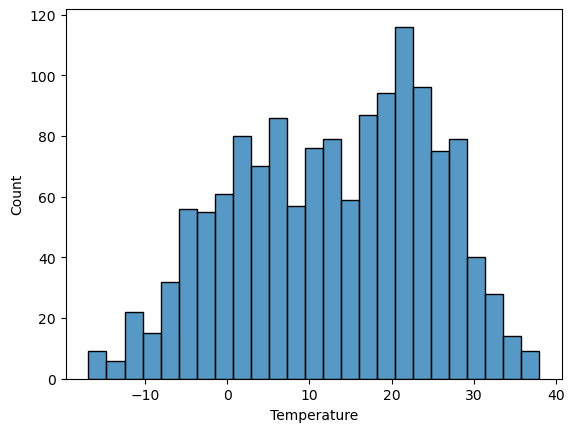

In [7]:
sns.histplot(x = 'Temperature',
             bins = 25,
             data = bikes)

In [8]:
# checking observations per month for different distribution of observations
bikes.groupby('Month')['Temperature'].count()

Month
Apr     132
Aug     113
Dec     111
Feb     106
Jan     141
July    125
June    125
Mar     108
May     126
Nov     100
Oct     118
Sep      96
Name: Temperature, dtype: int64

In [9]:
# CORRELATIONS
# instantiating correct correlation methods and creating feature sets
continuous     = ['SATURATED', 'Temperature', 'Humidity', 'WindSpeed', 'Visibility',
                  'DewPointTemperature', 'UVIndex', 'Precipitation', 'Snowfall']

non_continuous = ['SATURATED', 'Season', 'Month', 'DayofWeek', 'Hour', 'Holiday']


# pearson correlation
bikes_corr = bikes[continuous].corr(method     ="pearson",
                                    numeric_only=True).round(decimals = 4)


# phi coefficient
bikes_phi_corr = bikes[ non_continuous ].phik_matrix().round(decimals = 4)


# checking results
print(f"""
Point-Biserial Correlations
---------------------------
{bikes_corr.loc[ : , 'SATURATED' ].sort_values(ascending = False)}


Phi Coefficients
----------------
{bikes_phi_corr.loc[ : , 'SATURATED' ].sort_values(ascending = False)}
""")

interval columns not set, guessing: ['SATURATED', 'Hour']

Point-Biserial Correlations
---------------------------
SATURATED              1.0000
Temperature            0.5738
UVIndex                0.4175
DewPointTemperature    0.3965
Visibility             0.1797
WindSpeed              0.1060
Precipitation         -0.1146
Snowfall              -0.1755
Humidity              -0.2078
Name: SATURATED, dtype: float64


Phi Coefficients
----------------
SATURATED    1.0000
Season       0.7483
Month        0.7006
Hour         0.5916
Holiday      0.0682
DayofWeek    0.0562
Name: SATURATED, dtype: float64



<br>

# Data Processing

In [10]:
# converting SATURATED 0 into business failure (station is saturated)
# and 1 into business success (station is free)
bikes['SATURATED'] = 1 - bikes['SATURATED']

In [11]:
# PREPARING data to proceed with analysis 

# transforming categorial variables into binaries
bikes['Holiday'] = bikes['Holiday'].map({'Yes': 1, 'No': 0})

# transformin ordinal variables into integers
season_mapping = {'Winter': 1, 'Spring': 2, 'Summer': 3, 'Autumn': 4}
bikes['Season'] = bikes['Season'].map(season_mapping)

# get dummies for nominal categorical variables
bikes = pd.get_dummies(bikes, columns=['Month', 'DayofWeek', 'Hour'])

<br>

# Feature Engineering

In [12]:
# creating binary features for categorization
bikes['has_Rain_Snow'] = 0
bikes['is_Weekend']    = 0
bikes['Morning_Rush']  = 0
bikes['Evening_Rush']  = 0


#for loop with iterrow to go over every row
for index, value in bikes.iterrows():

    # has either rainfall or snowfall
    if value['Precipitation'] > 0 or value['Snowfall'] > 0:
        bikes.loc[index, 'has_Rain_Snow'] = 1
    
    # weekend
    if value[['DayofWeek_Saturday', 'DayofWeek_Sunday']].sum() > 0:
        bikes.loc[index, 'is_Weekend'] = 1

    # Rush hour 
    if value[['Hour_6', 'Hour_7', 'Hour_8', 'Hour_9']].sum() > 0:
        bikes.loc[index, 'Morning_Rush'] = 1
        
     # Rush hour 
    if value[['Hour_15', 'Hour_16', 'Hour_17', 'Hour_18', 'Hour_19']].sum() > 0:
        bikes.loc[index, 'Evening_Rush'] = 1

In [13]:
bikes['WeatherScore'] = (
    (bikes['Precipitation'] * 5) +             # heavy weight due to personal experience
    (bikes['Snowfall'] * 5) +                  # heavy weight due to personal experience
    (bikes['WindSpeed'] * 3 / 7.4) +           # medium weight, normalized to max 7.4
    ((38 - bikes['Temperature']) * 3 / 54.9) + # medium weight, normalized (38 max, -16.9 min)
    (bikes['Humidity'] * 1 / 98) +             # low weight, normalized to 0-1 scale
    ((2000 - bikes['Visibility']) * 1 / 1967)  # low weight, normalized (2000 max, 33 min)
    )

<br>

# Modeling

In [14]:
# declaring x variables
bikes_data   = bikes.loc[:, bikes.columns != 'SATURATED']

# declaring y variable
bikes_target = bikes.loc[ :, 'SATURATED' ]

In [15]:
# subsetting X-data
x_data = bikes.drop(columns=['SATURATED'])

# yeo-johnson transformation
x_transformed = power_transform(X           = x_data,
                                method      = 'yeo-johnson',
                                standardize = True        )


# storing results as a DataFrame
x_transformed_df = pd.DataFrame(data    = x_transformed,
                                columns = list(x_data.columns))

In [16]:
# standardizing X-data (st = scaled and transformed)
x_data_st = standard_scaler(df = x_transformed_df)


# checking results
x_data_st.describe(include = 'number').round(decimals = 2)

,Season,Temperature,Humidity,WindSpeed,Visibility,DewPointTemperature,UVIndex,Precipitation,Snowfall,Holiday,Month_Apr,Month_Aug,Month_Dec,Month_Feb,Month_Jan,Month_July,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,DayofWeek_Friday,DayofWeek_Monday,DayofWeek_Saturday,DayofWeek_Sunday,DayofWeek_Thursday,DayofWeek_Tuesday,DayofWeek_Wednesday,Hour_0,Hour_1,Hour_2,Hour_3,Hour_4,Hour_5,Hour_6,Hour_7,Hour_8,Hour_9,Hour_10,Hour_11,Hour_12,Hour_13,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23,has_Rain_Snow,is_Weekend,Morning_Rush,Evening_Rush,WeatherScore
count,1401.00,1401.00,1401.00,1401.00,1401.00,1401.00,1401.00,1401.00,1401.00,1401.00,1401.00,1401.00,1401.00,1401.00,1401.00,1401.00,1401.00,1401.00,1401.00,1401.00,1401.0,1401.00,1401.00,1401.00,1401.00,1401.0,1401.00,1401.00,1401.00,1401.00,1401.00,1401.00,1401.00,1401.00,1401.00,1401.00,1401.00,1401.00,1401.00,1401.00,1401.00,1401.00,1401.00,1401.00,1401.00,1401.0,1401.00,1401.0,1401.00,1401.00,1401.00,1401.00,1401.00,1401.00,1401.00,1401.00,1401.00,1401.00
mean,-0.00,0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,-0.0,-0.00,0.00,0.00,0.00,-0.0,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,0.0,-0.00,0.0,-0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.0,1.00,1.00,1.00,1.00,1.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.0,1.00,1.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-1.38,-2.56,-3.45,-2.54,-1.91,-2.31,-0.88,-0.27,-0.24,-0.22,-0.32,-0.30,-0.29,-0.29,-0.33,-0.31,-0.31,-0.29,-0.31,-0.28,-0.3,-0.27,-0.40,-0.42,-0.42,-0.4,-0.40,-0.41,-0.41,-0.21,-0.19,-0.21,-0.21,-0.21,-0.21,-0.18,-0.19,-0.22,-0.22,-0.22,-0.19,-0.25,-0.21,-0.22,-0.22,-0.2,-0.23,-0.2,-0.21,-0.22,-0.19,-0.19,-0.19,-0.37,-0.64,-0.44,-0.53,-4.48
25%,-1.38,-0.79,-0.74,-0.64,-0.93,-0.72,-0.88,-0.27,-0.24,-0.22,-0.32,-0.30,-0.29,-0.29,-0.33,-0.31,-0.31,-0.29,-0.31,-0.28,-0.3,-0.27,-0.40,-0.42,-0.42,-0.4,-0.40,-0.41,-0.41,-0.21,-0.19,-0.21,-0.21,-0.21,-0.21,-0.18,-0.19,-0.22,-0.22,-0.22,-0.19,-0.25,-0.21,-0.22,-0.22,-0.2,-0.23,-0.2,-0.21,-0.22,-0.19,-0.19,-0.19,-0.37,-0.64,-0.44,-0.53,-0.59
50%,-0.35,0.09,-0.01,-0.04,0.38,0.01,-0.64,-0.27,-0.24,-0.22,-0.32,-0.30,-0.29,-0.29,-0.33,-0.31,-0.31,-0.29,-0.31,-0.28,-0.3,-0.27,-0.40,-0.42,-0.42,-0.4,-0.40,-0.41,-0.41,-0.21,-0.19,-0.21,-0.21,-0.21,-0.21,-0.18,-0.19,-0.22,-0.22,-0.22,-0.19,-0.25,-0.21,-0.22,-0.22,-0.2,-0.23,-0.2,-0.21,-0.22,-0.19,-0.19,-0.19,-0.37,-0.64,-0.44,-0.53,0.03
75%,0.54,0.80,0.80,0.69,0.98,0.87,1.11,-0.27,-0.24,-0.22,-0.32,-0.30,-0.29,-0.29,-0.33,-0.31,-0.31,-0.29,-0.31,-0.28,-0.3,-0.27,-0.40,-0.42,-0.42,-0.4,-0.40,-0.41,-0.41,-0.21,-0.19,-0.21,-0.21,-0.21,-0.21,-0.18,-0.19,-0.22,-0.22,-0.22,-0.19,-0.25,-0.21,-0.22,-0.22,-0.2,-0.23,-0.2,-0.21,-0.22,-0.19,-0.19,-0.19,-0.37,1.57,-0.44,-0.53,0.54
max,1.35,2.09,1.77,3.09,0.98,1.88,1.68,3.72,4.24,4.65,3.10,3.38,3.41,3.50,2.99,3.19,3.19,3.46,3.18,3.61,3.3,3.69,2.49,2.41,2.38,2.5,2.49,2.44,2.44,4.77,5.20,4.77,4.69,4.73,4.77,5.43,5.14,4.65,4.50,4.57,5.31,4.06,4.77,4.57,4.53,4.9,4.43,4.9,4.73,4.57,5.31,5.25,5.37,2.71,1.57,2.29,1.90,2.65


In [17]:
# train-test split with stratification
x_train, x_test, y_train, y_test = train_test_split(
            bikes_data,
            bikes_target,
            test_size    = 0.25,
            random_state = 219,
            stratify     = bikes_target) # preserving balance


# merging training data for statsmodels
bikes_train = pd.concat([x_train, y_train], axis = 1)

In [18]:
# checking occurrence of saturation across dataset
print(f"""
Response Variable Proportions (Training Set)
--------------------------------------------
{y_train.value_counts(normalize = True).round(decimals = 4)}


Response Variable Proportions (Testing Set)
--------------------------------------------
{y_test.value_counts(normalize = True).round(decimals = 4)}
""")


Response Variable Proportions (Training Set)
--------------------------------------------
SATURATED
1    0.5029
0    0.4971
Name: proportion, dtype: float64


Response Variable Proportions (Testing Set)
--------------------------------------------
SATURATED
1    0.5014
0    0.4986
Name: proportion, dtype: float64



In [19]:
# instantiating a logistic regression model object
base = smf.logit(formula = """ SATURATED ~
                                         Season +
                                         Humidity + 
                                         UVIndex + 
                                         has_Rain_Snow +
                                         is_Weekend + 
                                         Morning_Rush + 
                                         Evening_Rush +
                                         Temperature +
                                         Visibility
                                         
                                         """,
                                     data=bikes_train)

# fitting the model object
base = base.fit()


# checking the results SUMMARY
base. summary2()

Optimization terminated successfully.
         Current function value: 0.344710
         Iterations 8


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Method:           MLE        
Dependent Variable: SATURATED        Pseudo R-squared: 0.503      
Date:               2025-03-14 19:17 AIC:              743.8909   
No. Observations:   1050             BIC:              793.4564   
Df Model:           9                Log-Likelihood:   -361.95    
Df Residuals:       1040             LL-Null:          -727.79    
Converged:          1.0000           LLR p-value:      1.0639e-151
No. Iterations:     8.0000           Scale:            1.0000     
------------------------------------------------------------------
                   Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
Intercept          1.6795   0.6089   2.7581 0.0058  0.4860  2.8731
Season            -0.7887   0.1056  -7.4703 0.0000 -0.9957 -0.5818
Humidity           0.0349   0.0074   4.7373 0.0000  0.0205  0.0494
UVIndex           -0.7529   0.1595  -4.7207 0.0000 -1.0655 -0.4403
has_Rain_Snow      2.6542   0.5312   4.9963 0.0000  1.6130  3.6954
is_Weekend         0.7424   0.2095   3.5442 0.0004  0.3319  1.1530
Morning_Rush      -1.2142   0.2614  -4.6459 0.0000 -1.7265 -0.7020
Evening_Rush      -1.5511   0.2753  -5.6342 0.0000 -2.0907 -1.0115
Temperature       -0.1344   0.0126 -10.6598 0.0000 -0.1591 -0.1097
Visibility         0.0004   0.0002   1.9990 0.0456  0.0000  0.0007
==================================================================

"""

In [20]:
# listing the x variables for logistic regression

# creating a dictionary to store candidate models
candidate_dict = {

    'base'  : ['Season','Humidity','UVIndex','has_Rain_Snow','is_Weekend',
               'Morning_Rush','Evening_Rush','Temperature', 'Visibility'],
    
    'all'   : ['Season','Temperature','Humidity','WindSpeed','Visibility',
             'DewPointTemperature', 'UVIndex','Precipitation', 'Snowfall',
             'Holiday', 'Month_Apr', 'Month_Aug', 'Month_Dec', 'Month_Feb', 
             'Month_Jan', 'Month_July', 'Month_June', 'Month_Mar', 'Month_May', 
             'Month_Nov', 'Month_Oct', 'Month_Sep', 'DayofWeek_Friday', 
             'DayofWeek_Monday', 'DayofWeek_Saturday', 'DayofWeek_Sunday',
             'DayofWeek_Thursday', 'DayofWeek_Tuesday', 'DayofWeek_Wednesday',
             'Hour_0','Hour_1', 'Hour_2', 'Hour_3', 'Hour_4', 'Hour_5', 
             'Hour_6', 'Hour_7', 'Hour_8', 'Hour_9', 'Hour_10', 'Hour_11', 
             'Hour_12', 'Hour_13','Hour_14', 'Hour_15', 'Hour_16', 
             'Hour_17', 'Hour_18', 'Hour_19', 'Hour_20', 'Hour_21', 'Hour_22', 
             'Hour_23','has_Rain_Snow', 'is_Weekend','Morning_Rush', 
             'Evening_Rush', 'WeatherScore'],
    
    
    'logit' : ['Season', 'Humidity', 'UVIndex', 'has_Rain_Snow', 
                'is_Weekend', 'Morning_Rush', 'Evening_Rush' ,
                 'Temperature', 'Visibility' ],
    

    'tree' : ['Season','Temperature','Humidity','WindSpeed',
             'UVIndex','Morning_Rush'],
    
    'forest' : ['Season', 'Temperature', 'Humidity', 'WindSpeed', 'Visibility',
               'DewPointTemperature', 'UVIndex', 'Month_May', 'Hour_2',
               'Hour_3', 'Hour_4', 'Hour_5', 'Hour_6', 'Hour_8', 'Hour_18',
               'Hour_22', 'is_Weekend', 'Evening_Rush', 'WeatherScore' ],

    
    'gradient' : ['Season', 'Temperature', 'Humidity', 'WindSpeed', 
                  'Visibility', 'DewPointTemperature', 'UVIndex', 
                  'Month_May', 'Hour_2', 'Hour_3', 'Hour_4', 'Hour_5', 
                  'Hour_6', 'Hour_8', 'Hour_18', 'Hour_22', 'is_Weekend',
                  'Evening_Rush','WeatherScore']
             
    }

<br>

## Logistic Regression

In [21]:
# train/test split with the full model
x_data_log =  x_data_st[ candidate_dict['logit'] ]
y_data_log =  bikes  [ 'SATURATED' ]


# this is the exact code we were using before
x_train, x_test, y_train, y_test = train_test_split(
            x_data_log,
            y_data_log,
            random_state = 702,
            test_size    = 0.25,
            stratify     = y_data_log)

In [22]:
# INSTANTIATING a logistic regression model
logreg = sklearn.linear_model.LogisticRegression(solver = 'lbfgs',
                                                 C = 1,
                                                 random_state = 702)


# FITTING the training data
logreg_fit = logreg.fit(x_train, y_train)


# PREDICTING based on the testing set
logreg_pred = logreg_fit.predict(x_test)


# saving scoring data for future use
train_score = round(logreg_fit.score(x_train, y_train), ndigits = 4) # train accuracy
test_score  = round(logreg_fit.score(x_test, y_test),   ndigits = 4) # test accuracy
tt_gap      = round(abs(train_score - test_score),      ndigits = 4) # gap

# using the classification_summary function
classification_summary(x          = x_data_log,
                       y          = y_data_log,
                       model      = logreg,
                       model_name = "Logistic Regression")


    Results for Logistic Regression
    Model Type: LogisticRegression(C=1, random_state=702)
    Training Samples: 1050 
    Testing  Samples: 351
    
    
    Summary Statistics
    ------------------
    AUC (Train): 0.8457
    AUC (Test) : 0.8462
    TT Gap     : 0.0005
    
    
    Confusion Matrix (test set)
    ---------------------------
    True Negatives : 150
    False Positives: 25
    False Negatives: 29
    True Positives : 147
    


<br>

## Classification Tree


    Results for Age Tree
    Model Type: DecisionTreeClassifier(max_depth=4, min_samples_leaf=0.05, random_state=708)
    Training Samples: 1050 
    Testing  Samples: 351
    
    
    Summary Statistics
    ------------------
    AUC (Train): 0.8301
    AUC (Test) : 0.829
    TT Gap     : 0.0011
    
    
    Confusion Matrix (test set)
    ---------------------------
    True Negatives : 139
    False Positives: 36
    False Negatives: 24
    True Positives : 152
    


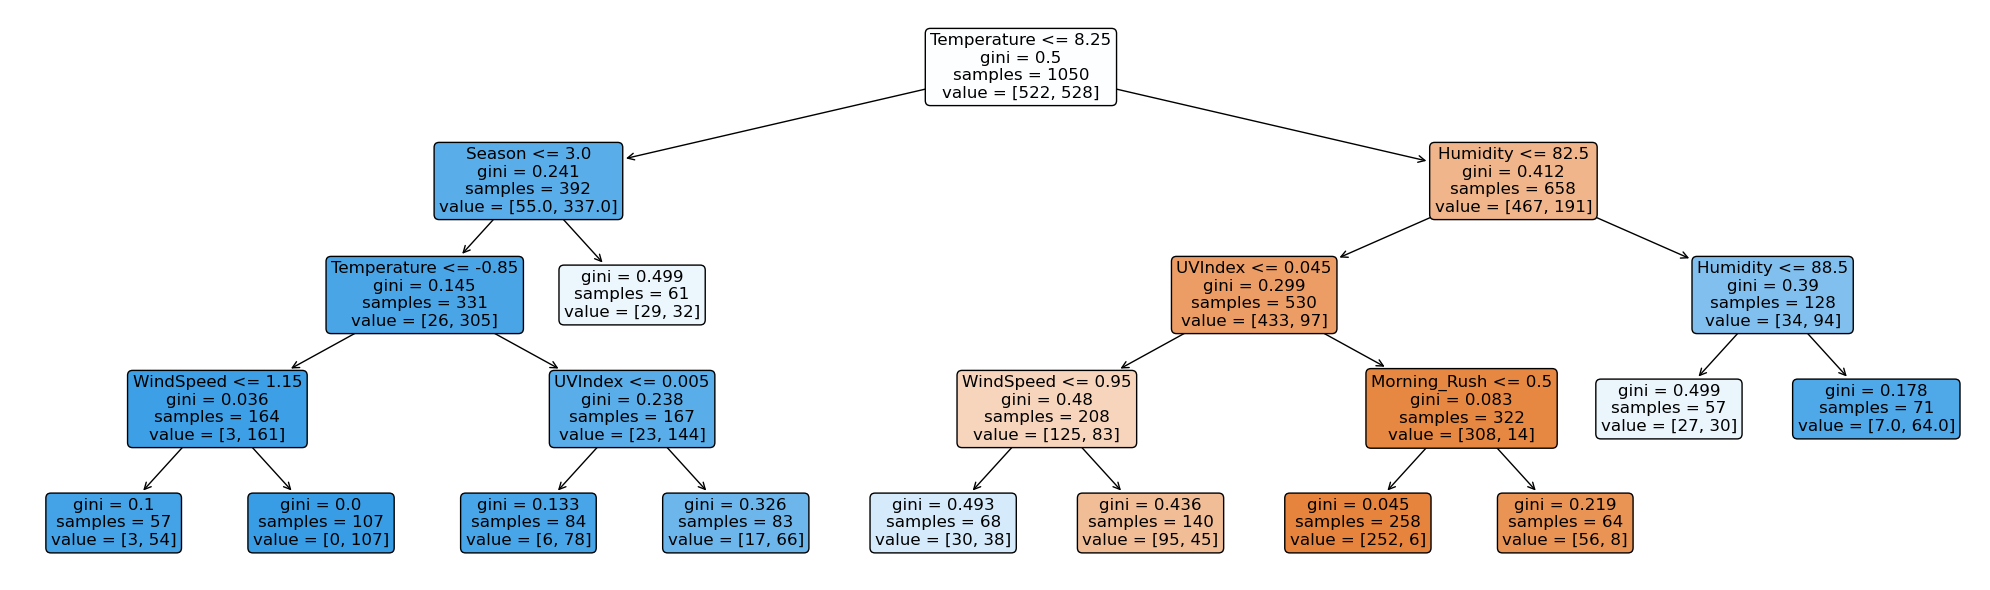

In [23]:
# Instantiating classification tree
# preparing to partition data
x_data_CT =  bikes[ candidate_dict['tree'] ]


y_data_CT =  bikes_target


# instantiating a classification tree
tree_model = DecisionTreeClassifier(max_depth        = 4,
                                    min_samples_leaf = 0.05,
                                    random_state     = 708)


# using the classification_summary function
classification_summary(x          = x_data_CT,
                       y          = y_data_CT,
                       model      = tree_model,
                       model_name = "Age Tree")


# setting figure size
plt.figure(figsize=(20, 6)) # adjust if boxes are overlapping


# developing a plotted tree
plot_tree(decision_tree = tree_model,
          feature_names = x_data_CT.columns,
          filled        = True, 
          rounded       = True, 
          fontsize      = 12) # adjust if boxes are overlapping


# rendering the plot
plt.tight_layout()
plt.show()

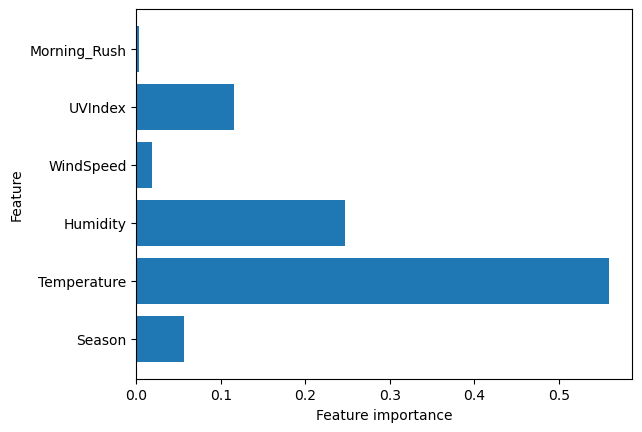

In [24]:
# plotting feature importance
plot_feature_importances_CT(model  = tree_model,
                         train  = x_data_CT,
                         export = False)

<br>

## Random Forest

In [25]:
# INSTANTIATING a random forest model
# preparing to partition data
x_data_RF =  bikes[ candidate_dict['forest'] ]

y_data_RF =  bikes_target


In [26]:
# building a model based on hyperparameter tuning results

# INSTANTIATING a random forest
model = RandomForestClassifier(bootstrap        = False,
                               n_estimators     = 200,
                               criterion        = 'gini',
                               min_samples_leaf = 21,
                               random_state     = 702,
                               warm_start       = True)


# using the classification_summary function
classification_summary(x          = x_data_RF,
                       y          = y_data_RF,
                       model      = model,
                       model_name = "Tuned Random Forest")


    Results for Tuned Random Forest
    Model Type: RandomForestClassifier(bootstrap=False, min_samples_leaf=21, n_estimators=200,
                       random_state=702, warm_start=True)
    Training Samples: 1050 
    Testing  Samples: 351
    
    
    Summary Statistics
    ------------------
    AUC (Train): 0.9143
    AUC (Test) : 0.9145
    TT Gap     : 0.0002
    
    
    Confusion Matrix (test set)
    ---------------------------
    True Negatives : 160
    False Positives: 15
    False Negatives: 15
    True Positives : 161
    


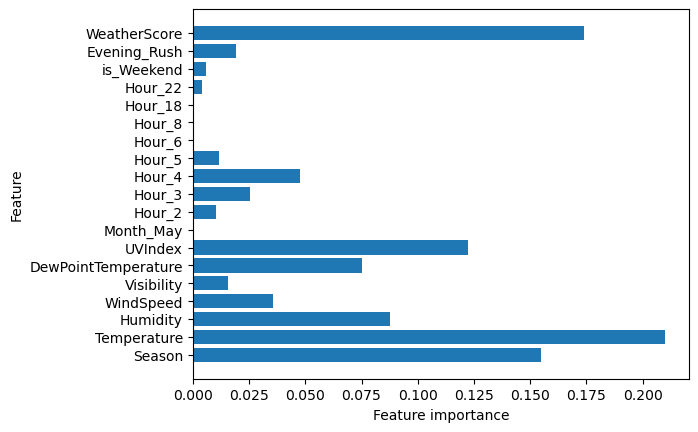

In [27]:
# plotting feature importances
plot_feature_importances_RF(model = model,
                            train = x_data_RF)

<br>

## Gradient Boosted Machine

In [28]:
# INSTANTIATING a random forest model
# preparing to partition data
x_data_GB =  bikes[ candidate_dict['gradient'] ]

y_data_GB =  bikes_target


In [30]:
# building Gradient Boosted model based on hyperparameter tuning results

# INSTANTIATING the model object with hyperparameters
model = GradientBoostingClassifier(loss          = 'exponential',
                                   learning_rate = 0.03,
                                   n_estimators  = 100,
                                   criterion     = 'friedman_mse',
                                   max_depth     = 2,
                                   warm_start    = True,
                                   random_state  = 702)


# using the classification_summary function
classification_summary(x          = x_data_GB,
                       y          = y_data_GB,
                       model      = model,
                       model_name = "Gradient Boosted Machine")


    Results for Gradient Boosted Machine
    Model Type: GradientBoostingClassifier(learning_rate=0.03, loss='exponential', max_depth=2,
                           random_state=702, warm_start=True)
    Training Samples: 1050 
    Testing  Samples: 351
    
    
    Summary Statistics
    ------------------
    AUC (Train): 0.9096
    AUC (Test) : 0.9089
    TT Gap     : 0.0007
    
    
    Confusion Matrix (test set)
    ---------------------------
    True Negatives : 162
    False Positives: 13
    False Negatives: 19
    True Positives : 157
    


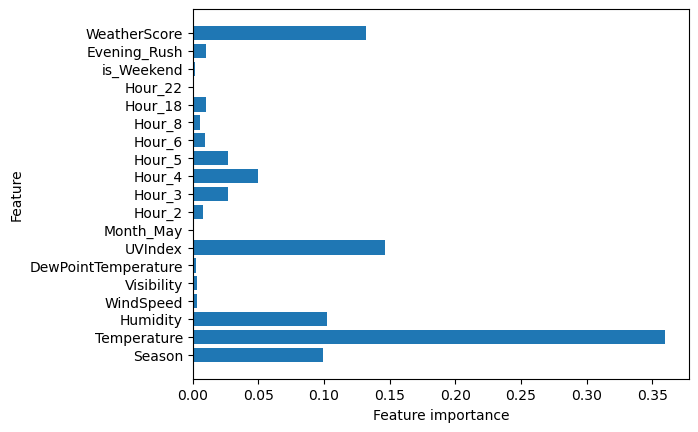

In [31]:
# plotting feature importances
plot_feature_importances_GB(model = model,
                            train = x_data_GB)

<br>

# Final Model Selection

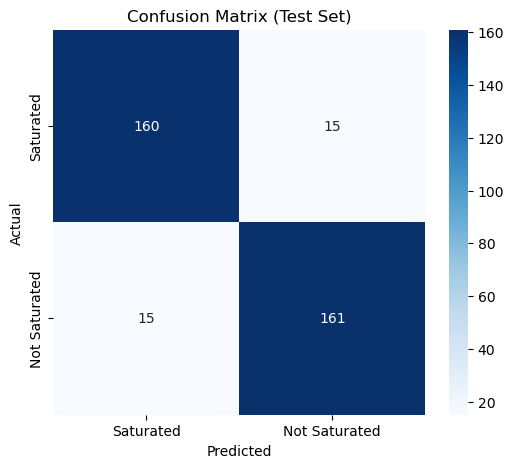

In [32]:
# hard coding values of heatmap from Random Forest Model
conf_matrix = np.array([[160, 15],  # True Negatives (TN), False Positives (FP)
                        [15, 161]]) # False Negatives (FN), True Positives (TP)

# Defining class labels
labels = ["Saturated", "Not Saturated"]

# Creating a heatmap for the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)

# Formatting the plot
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Test Set)")

# Show the plot
plt.show()

Based on the analysis, Random Forest is the best model to predict dock saturation for Bay Wheels. It has the highest AUC test score (0.9143) and train score (0.9145 with the lowest train-test-gap (0.0002). The model performs equally well on training and test data. There is almost no overfitting, meaning the model generalizes well and is flexible enough for new data in the future. <br>
Furthermore, Random Forest is the model with the lowest number of total false predictions and the lowest number of false negative predictions (why this is especially important will be explained in step 6.5). <br>
The confusion matrix shows that the Random Forest model correctly predicts 160 cases with saturated docks and 161 with not-saturated docks. Only 15 times for each scenario, the model was wrong. 

<br>

# Analysis

## Purpose for Using Bikes

<Figure size 1200x600 with 0 Axes>

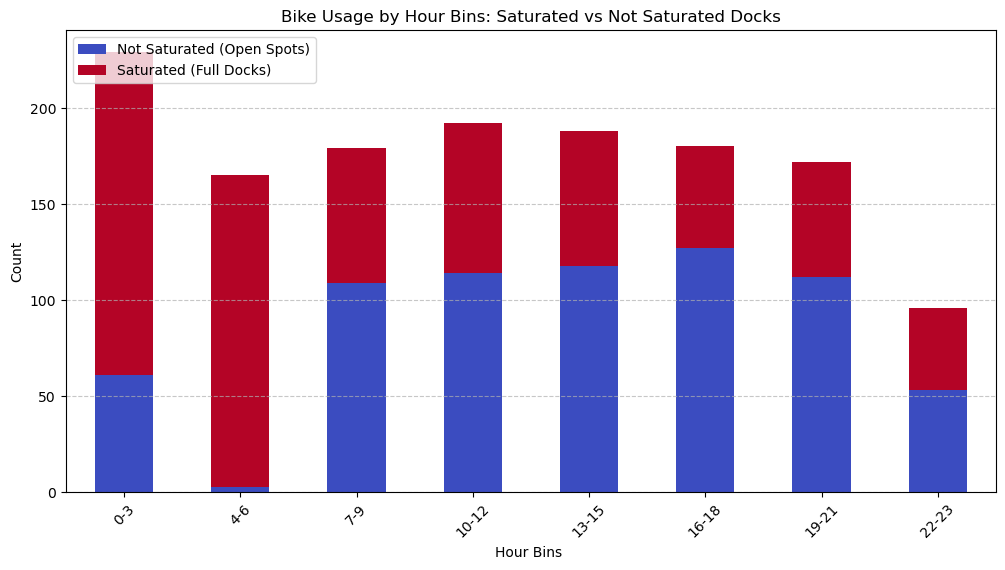

In [33]:
# Identifying actual hour columns in the dataset
hour_columns = [col for col in bikes.columns if col.startswith('Hour_')]
hour_labels = [int(col.split('_')[1]) for col in hour_columns]  # Extracting numerical hour values

# Defining 3-hour bins dynamically
hour_bins = {
    '0-3': [col for col in hour_columns if 0 <= int(col.split('_')[1]) <= 3],
    '4-6': [col for col in hour_columns if 4 <= int(col.split('_')[1]) <= 6],
    '7-9': [col for col in hour_columns if 7 <= int(col.split('_')[1]) <= 9],
    '10-12': [col for col in hour_columns if 10 <= int(col.split('_')[1]) <= 12],
    '13-15': [col for col in hour_columns if 13 <= int(col.split('_')[1]) <= 15],
    '16-18': [col for col in hour_columns if 16 <= int(col.split('_')[1]) <= 18],
    '19-21': [col for col in hour_columns if 19 <= int(col.split('_')[1]) <= 21],
    '22-23': [col for col in hour_columns if 22 <= int(col.split('_')[1]) <= 23]
}

# Creating a DataFrame to store aggregated counts
hour_bin_counts = pd.DataFrame(index=hour_bins.keys(), columns=['Saturated', 'Not_Saturated'])

# Summing occurrences of SATURATED (0 = full docks) and NOT SATURATED (1 = bikes taken) per hour bin
for bin_label, hours in hour_bins.items():
    # Ensuring only valid columns are selected
    valid_hours = [col for col in hours if col in bikes.columns]
    
    if valid_hours:  # Only process if columns exist
        total_not_saturated = bikes[valid_hours].T.dot(bikes['SATURATED'])  # Total not saturated per bin (1 = bikes taken)
        total_saturated = bikes[valid_hours].sum().sum() - total_not_saturated.sum()  # Total - NOT SATURATED = Saturated

        # Storing in DataFrame
        hour_bin_counts.loc[bin_label, 'Not_Saturated'] = total_not_saturated.sum()
        hour_bin_counts.loc[bin_label, 'Saturated'] = total_saturated.sum()

# Converting to numeric values
hour_bin_counts = hour_bin_counts.astype(int)

# Plotting the bar chart
plt.figure(figsize=(12, 6))
hour_bin_counts.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='coolwarm')

# Labels and title
plt.xlabel('Hour Bins ')
plt.ylabel('Count')
plt.title('Bike Usage by Hour Bins: Saturated vs Not Saturated Docks')
plt.legend(["Not Saturated (Open Spots)", "Saturated (Full Docks)"], loc='upper left')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.show()

The analysis shows that dock saturation drastically decreases once the commuting hours (7-9) start. This means, more bikes are taken out of the docks now. During these hours, it is probable that people use them to commute to work, e.g. from their apartment to the office to avoid full buses or metros. <br>
After the morning commuting hours, the demand of bikes stays on the same level, with more stations having an open spot than full ones. During this time, the usage of the bikes is probably due to recreational purposes, e.g. for people that work shifts or students that are off during the day. <br>
The usage of bikes peaks between 16-18 o'clock, meaning this is the time of the day where most bikes are in usage and not sitting in the docks. This is probably due to the combination of people using the bikes for recreational purposes as well as commuting home from work.<br>
The usage decreases slightly after 18 o'clock, probably due to the commuters arriving at home. Now, the usage is most likely due to recreational or exercising purposes. People might choose a bike over going to a crowded gym in these "work-out rush-hours". 

<br>

## Ideal Temperature

/var/folders/jz/l65kvw9n2ln9h101ztwmvl980000gn/T/ipykernel_73629/1295896253.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp_bin_saturation_counts = bikes.groupby('Temp_Binned')['SATURATED'].value_counts().unstack()


<Figure size 1200x600 with 0 Axes>

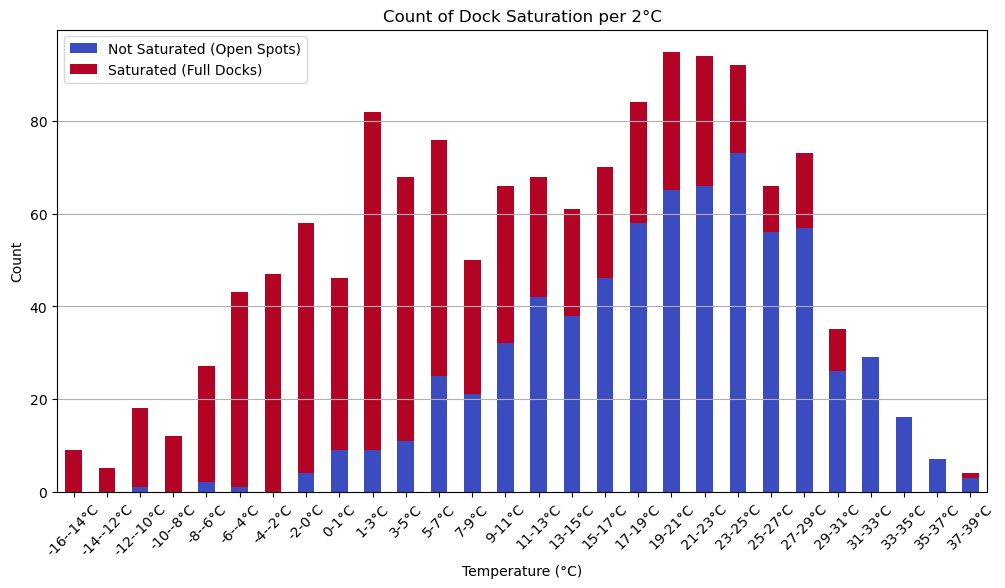

In [34]:
# Defining temperature bins (every 2°C for grouping)
bins = np.arange(bikes['Temperature'].min(), bikes['Temperature'].max() + 2, 2)
labels = [f"{int(b)}-{int(b+2)}°C" for b in bins[:-1]]

# Creating a new column for binned temperature ranges (2°C bins)
bikes['Temp_Binned'] = pd.cut(bikes['Temperature'], bins=bins, labels=labels, include_lowest=True)

# Grouping by temperature bins and counting occurrences of SATURATED (0) and NOT SATURATED (1)
temp_bin_saturation_counts = bikes.groupby('Temp_Binned')['SATURATED'].value_counts().unstack()

# Plotting the counts of NOT SATURATED (bikes taken) and SATURATED (full docks) per temperature bin (2°C steps)
plt.figure(figsize=(12, 6))
temp_bin_saturation_counts[[0, 1]].plot(kind='bar', stacked=True, figsize=(12, 6), colormap='coolwarm')

# Labels and title
plt.xlabel('Temperature (°C)')
plt.ylabel('Count')
plt.title('Count of Dock Saturation per 2°C')
plt.legend(["Not Saturated (Open Spots)", "Saturated (Full Docks)"], loc='upper left')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Show plot
plt.show()


When the temperature is "ideal", the dock saturation decreases because more bikes are in use. This frees up spots on the docking stations. In the case of this analysis, the ideal temperature for biking is evaluated based on the portion of saturated stations, with less stations being saturated being a more ideal temperature for biking. <br>
According to the data, the ideal temperature for biking is in the range of  23 to 29 degrees Celsius. This resonates with further research, suggesting that a temperature in the mid 20s is ideal for cycling*. The purpose for the usage of the bikes probably changing with increasing temperature. But ignoring the purpose of usage, this the range that described the "ideal temperature". It is important to state that the number of observations decrease with temperatures exceeding 29 degrees Celsius, as they were simply not so many days with temperatures beyond that threshold. <br>
<br>
*Windy.app. (n.d.). The bicycle riding temperature: hot, cold and ideal, and how to dress for it. https://windy.app/blog/bicycle-riding-temperature.html

<br>

## Time-Related Saturation Patterns

<Figure size 1200x600 with 0 Axes>

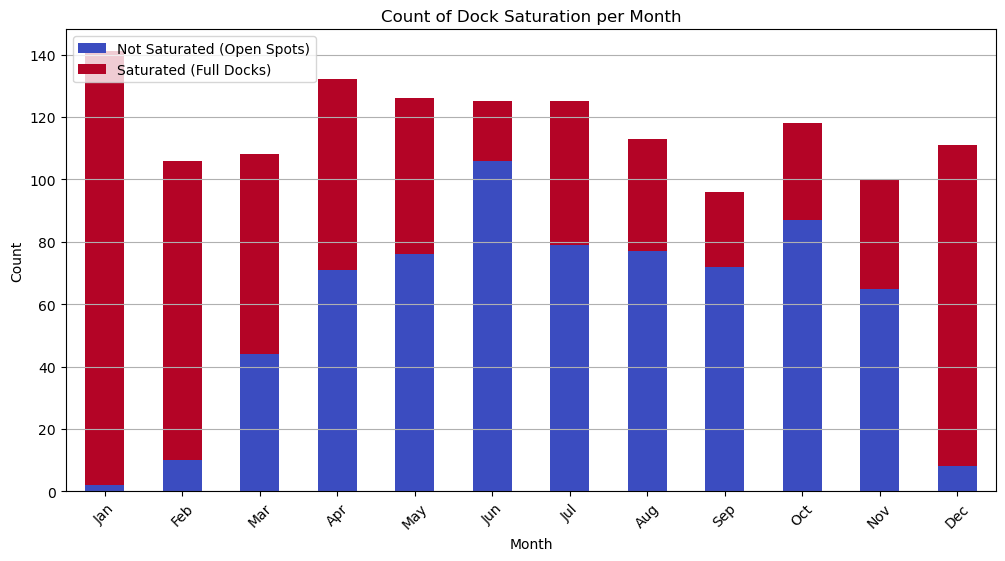

In [35]:
# Defining the correct month order for plotting
month_order = ['Month_Jan', 'Month_Feb', 'Month_Mar', 'Month_Apr', 'Month_May', 
               'Month_June', 'Month_July', 'Month_Aug', 'Month_Sep', 'Month_Oct', 
               'Month_Nov', 'Month_Dec']

# Creating a DataFrame to store aggregated counts
month_saturation_counts = pd.DataFrame(index=month_order, columns=['Saturated', 'Not_Saturated'])

# Summing occurrences of SATURATED (0 = full docks) and NOT SATURATED (1 = bikes taken) per month
for month in month_order:
    if month in bikes.columns:
        total_not_saturated = bikes[month].T.dot(bikes['SATURATED'])  # Total not saturated per month (1 = bikes taken)
        total_saturated = bikes[month].sum() - total_not_saturated  # Total - NOT SATURATED = Saturated

        # Storing in DataFrame
        month_saturation_counts.loc[month, 'Not_Saturated'] = total_not_saturated
        month_saturation_counts.loc[month, 'Saturated'] = total_saturated


# Renaming months for better readability in the plot
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Plotting the stacked bar chart
plt.figure(figsize=(12, 6))
month_saturation_counts.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='coolwarm')

# Labels and title
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Count of Dock Saturation per Month')
plt.legend(["Not Saturated (Open Spots)", "Saturated (Full Docks)"], loc='upper left')
plt.xticks(ticks=range(12), labels=month_labels, rotation=45)
plt.grid(axis='y')

# Show plot
plt.show()

After having interpreted the hourly patterns in step 6.1, this plot shows the dock saturation per month. In the winter months January and February, dock saturation is very high. In the cold temperatures, as seen in step 6.2, not many people use bikes. Since not many bikes are in use, this leaves the docking stations saturated. In spring, usage starts to pick up, reducing the amount of saturated stations because more bikes are in use. In the summer months, June is the month the highest bike usage (least saturated stations). It is not too hot, typically little precipitation, and more hours of sunlight. The usage is higher than in July and August because the weather can get too hot, leaving more docks full. Once temperatures start to cool down a little bit, the portion of full docks decreases again, aligning with the phenomenon when having "ideal" temperatures, like in June. In November, bike usage is still high due to the fact that there are still many nice and sunny days. Going into December and kicking off the holiday season with less people commuting and more people spending time inside, dock saturation increases as bike usage declines.

<br>

## Most Important Factors To Predict Dock Saturation

In [36]:
# Computing correlations between all features and dock saturation
bikes = bikes.drop(columns = 'Temp_Binned')

In [37]:
# checking correlations of all factors
bikes_correlation = bikes.corr()
print(bikes_correlation['SATURATED'].sort_values(ascending = False))

SATURATED              1.000000
Month_Jan              0.323364
has_Rain_Snow          0.323341
Month_Dec              0.249592
Month_Feb              0.230692
WeatherScore           0.218388
Hour_4                 0.210471
Hour_5                 0.208631
Humidity               0.207831
Hour_3                 0.198305
Snowfall               0.175479
Hour_6                 0.159299
Hour_2                 0.123338
Precipitation          0.114604
is_Weekend             0.083551
DayofWeek_Saturday     0.069887
Holiday                0.054456
Month_Mar              0.052077
DayofWeek_Sunday       0.037353
Hour_10                0.033093
Hour_1                 0.029820
Hour_0                 0.023830
Hour_23                0.018890
Morning_Rush          -0.000241
DayofWeek_Wednesday   -0.002051
DayofWeek_Tuesday     -0.018307
Month_Apr             -0.026045
DayofWeek_Monday      -0.026261
Hour_7                -0.027649
DayofWeek_Friday      -0.030935
DayofWeek_Thursday    -0.030935
Hour_14 

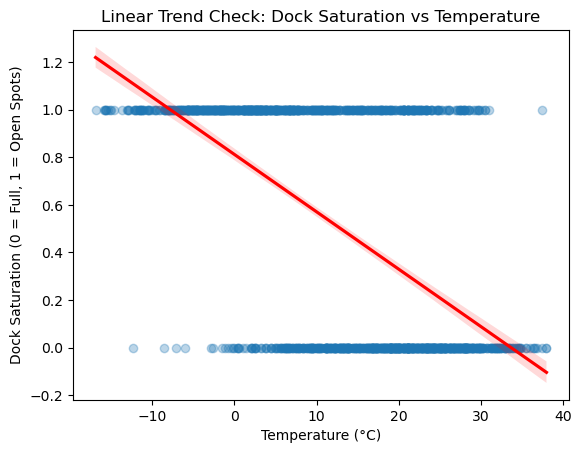

In [38]:
# Visualizing relationship of Temperature and Saturation because it has 
# the strongest correlation

# Scatter plot with regression line
sns.regplot(data=bikes, x="Temperature", y="SATURATED", scatter_kws={"alpha":0.3}, line_kws={"color":"red"})

# Labels and title
plt.xlabel("Temperature (°C)")
plt.ylabel("Dock Saturation (0 = Full, 1 = Open Spots)")
plt.title("Linear Trend Check: Dock Saturation vs Temperature")
plt.show()

Based on the feature importance and the correlation of x-variables with the dock saturation, it becomes clear that temperature is the most important factor to predict dock saturation. As Temperatures increase, dock saturation decreases. To confirm this, x-variables like the month of January or precipitation is moderately positive correlated with dock saturation, meaning that in these cases dock saturation tends to increase.<br>
This trend appears to be linear. As temperatures increase, dock saturation decreases to the same degree. Though, this is only true for the range of temperatures given in the dataset. Even though the data does not clearly indicate it, it is to assume that dock saturation will increase again once temperatures exceed a certain threshold, as seen in the months of July and August (step 6.3). 

<br>

## Analytical Error Control

Generally speaking, it is more important to get avoid false negatives. False negatives mean that a dock is predicted to have an open spot, even though it is actually full. Despite the fact that a model might perform a little worse, it is important to avoid these scenarios. The customer satisfaction when arriving at a dock which was supposedly free but is actually full will drop immensely. <br>
On the other hand, false positives mean that a dock is predicted to be full even though it has an open spot. These false predictions this might lead to the customer having to drive to another docking station, but at least they will not be negatively surprised when arriving there. False positives are a "safety guard" for avoiding bad surprises to the customer. This might have a negative impact on dock efficiency, but is saved the customer base from getting dissatisfied. <br>
<br>
The impact on customer satisfaction from arriving at a full dock due to false negatives is much higher compared to the minor inconvenience of having to use the second closest dock to the preferred destination due to false positives. Therefore, the conclusion is that false negatives are a more critical error.